In [2]:
import pandas as pd
import numpy as np
import pickle
import time
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb
import matplotlib.pyplot as plt
import sys
import gc
import seaborn as sns

C:\Users\Nobody\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
def save_pkl(file_dir, data):
    f = open(file_dir,"wb")
    pickle.dump(data, f, protocol=4)
    f.close()
    
def read_pkl(file_dir):
    f = open(file_dir,"rb")
    data = pickle.load(f)
    return data

def mape_error(y_true, y_pred):
    return -np.sqrt(np.sum((y_pred - y_true) * (y_pred - y_true)) * 1.0 / y_true.shape[0])

def scoring(reg, x, y):
    pred = reg.predict(x)
    return smape(pred, y)

def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (y_true + y_pred) * 2)

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg")
    plt.plot([min_val, max_val], [min_val, max_val],'m--')
    plt.title(title, fontsize=9)
    plt.show()

In [2]:
# load the whole size dataset
X = np.load("Aal/X_m.npy")
Y_NO2 = np.load("Aal/Y_NO2_m.npy")
Y_NOx = np.load("Aal/Y_NOx_m.npy")


# NOx

In [3]:
# split the Y_PM25, X into training part and testing part
train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx = train_test_split(X, Y_NOx, test_size=0.2, random_state=11)
print(train_X_NOx.shape, test_X_NOx.shape, train_Y_NOx.shape, test_Y_NOx.shape)

(730828, 198) (182708, 198) (730828,) (182708,)


In [5]:
#XGBoost
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    gamma=0.8,
    min_child_weight=2,
    reg_alpha=0.001,
    max_delta_step=0,
    colsample_bylevel=0.9,
    colsample_bytree=0.8, 
    subsample=0.8,
    base_score=10,
    eta=0.3,    
    seed=1)

model.fit(
    train_X_NOx, 
    train_Y_NOx, 
    eval_metric="rmse", 
    eval_set=[(train_X_NOx, train_Y_NOx), (test_X_NOx, test_Y_NOx)], 
    verbose=True, 
    early_stopping_rounds = 10)

pred = model.predict(test_X_NOx)
print (smape(pred, test_Y_NOx))
time.time() - ts

[0]	validation_0-rmse:15.37935	validation_1-rmse:15.39473
[1]	validation_0-rmse:11.35785	validation_1-rmse:11.38101
[2]	validation_0-rmse:8.65136	validation_1-rmse:8.68688
[3]	validation_0-rmse:6.87796	validation_1-rmse:6.92649
[4]	validation_0-rmse:5.72855	validation_1-rmse:5.80149
[5]	validation_0-rmse:4.97504	validation_1-rmse:5.07628
[6]	validation_0-rmse:4.46977	validation_1-rmse:4.59866
[7]	validation_0-rmse:4.14048	validation_1-rmse:4.28892
[8]	validation_0-rmse:3.93360	validation_1-rmse:4.09745
[9]	validation_0-rmse:3.73786	validation_1-rmse:3.91809
[10]	validation_0-rmse:3.62551	validation_1-rmse:3.81507
[11]	validation_0-rmse:3.54887	validation_1-rmse:3.74918
[12]	validation_0-rmse:3.45374	validation_1-rmse:3.67012
[13]	validation_0-rmse:3.39134	validation_1-rmse:3.61559
[14]	validation_0-rmse:3.31602	validation_1-rmse:3.54930
[15]	validation_0-rmse:3.25734	validation_1-rmse:3.49654
[16]	validation_0-rmse:3.18474	validation_1-rmse:3.43141
[17]	validation_0-rmse:3.13062	valida

1315.2482566833496

In [6]:
save_pkl("Aal/xgboost_NOx.model", model)

In [7]:
test_X = np.load("Aal/X_test.npy")
test_Y = np.load("Aal/Y_PM25_test.npy")
pred = model.predict(test_X)
print (smape(pred, test_Y))

0.9635482314243669


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

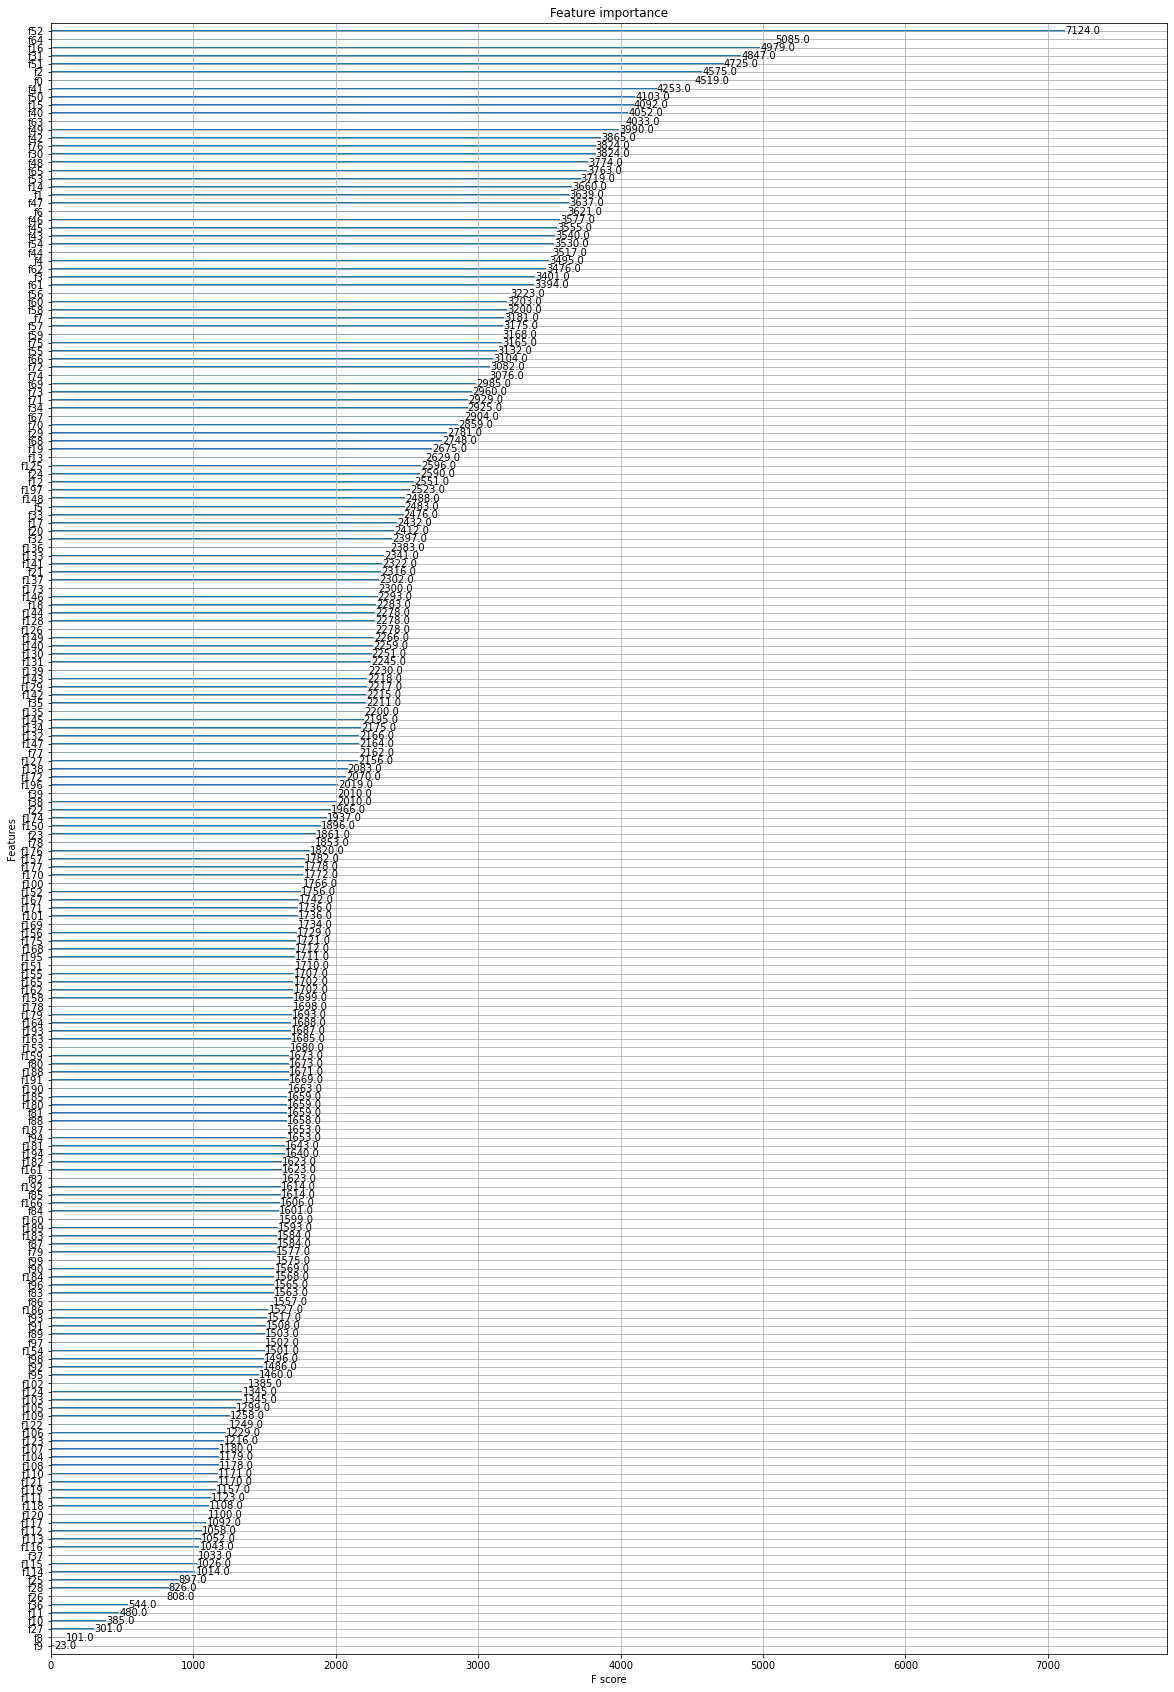

In [8]:
plot_features(model, (20,30))

# NO2

In [9]:
# split the Y_NO2, X into training part and testing part
train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2 = train_test_split(X, Y_NO2, test_size=0.2, random_state=11)
print(train_X_NO2.shape, test_X_NO2.shape, train_Y_NO2.shape, test_Y_NO2.shape)

(730828, 198) (182708, 198) (730828,) (182708,)


In [10]:
#XGBoost
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    learning_rate=0.001,
    n_estimators=1000,
    gamma=0.8,
    min_child_weight=2,
    reg_alpha=0.001,
    max_delta_step=0,
    colsample_bylevel=0.9,
    colsample_bytree=0.8, 
    subsample=0.8,
    base_score=10,
    eta=0.3,    
    seed=1,
    nthread=30)

model.fit(
    train_X_NO2, 
    train_Y_NO2, 
    eval_metric="rmse", 
    eval_set=[(train_X_NO2, train_Y_NO2), (test_X_NO2, test_Y_NO2)], 
    verbose=True, 
    early_stopping_rounds = 10)

pred = model.predict(test_X_NO2)
print (smape(pred, test_Y_NO2))
time.time() - ts

[0]	validation_0-rmse:53.20722	validation_1-rmse:53.09923
[1]	validation_0-rmse:53.15735	validation_1-rmse:53.04952
[2]	validation_0-rmse:53.10758	validation_1-rmse:52.99987
[3]	validation_0-rmse:53.05794	validation_1-rmse:52.95027
[4]	validation_0-rmse:53.00837	validation_1-rmse:52.90084
[5]	validation_0-rmse:52.95878	validation_1-rmse:52.85137
[6]	validation_0-rmse:52.91034	validation_1-rmse:52.80314
[7]	validation_0-rmse:52.86189	validation_1-rmse:52.75485
[8]	validation_0-rmse:52.81249	validation_1-rmse:52.70554
[9]	validation_0-rmse:52.76394	validation_1-rmse:52.65717
[10]	validation_0-rmse:52.71462	validation_1-rmse:52.60793
[11]	validation_0-rmse:52.66536	validation_1-rmse:52.55873
[12]	validation_0-rmse:52.61602	validation_1-rmse:52.50950
[13]	validation_0-rmse:52.56676	validation_1-rmse:52.46042
[14]	validation_0-rmse:52.51767	validation_1-rmse:52.41141
[15]	validation_0-rmse:52.46855	validation_1-rmse:52.36241
[16]	validation_0-rmse:52.41948	validation_1-rmse:52.31342
[17]	va

1757.3288023471832

In [11]:
save_pkl("Aal/xgboost_NO2.model", model)

In [ ]:
test_X = np.load("Aal/X_test.npy")
test_Y = np.load("Aal/Y_No2_test.npy")
pred = model.predict(test_X)
print (smape(pred, test_Y))

In [ ]:
plot_features(model, (20,20))

# grid search for pm25

In [4]:
#grid search 
params = {
    # 'objective': reg:linear,
    'max_depth': 5,
    # 'learning_rate':0.001,
    'learning_rate': 0.001,
    'n_estimators': 2000,
    'gamma': 0.0,
    'min_child_weight': 2,
    'max_delta_step': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.6,
    'colsample_bylevel': 0.9,
    'base_score': 10,
    'seed': 1
}

'''
'max_depth': 10,
'learning_rate': 0.001,
# 'learning_rate': 0.02,
'n_estimators': 3000,
'gamma': 0.8,
'min_child_weight': 2,
'reg_alpha': 0.001,
'max_delta_step': 0,
'subsample': 0.8,
'colsample_bytree': 0.8,
'colsample_bylevel': 0.9,
'base_score': 10,
'seed': 1,
'nthread': 10
'''

param_test1 = {
    'max_depth': range(7, 12, 2),
    'min_child_weight': [2],
    'gamma': [i / 10.0 for i in range(8, 9)],
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)],
    'reg_alpha': [0, 0.001, 0.001],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [1000, 2000, 3000]
}

param_test3 = {
    'gamma': [i / 10.0 for i in range(0, 10)]
}

param_test4 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}

param_test6 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

param_test7 = {
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
}

param_test8 = {
    'learning_rate': [0.001, 0.002, 0.005, 0.01, 0.1],
    'n_estimators': [2000, 3000, 4000],
}

In [7]:
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=2)
estimator=xgb.XGBRegressor(
    learning_rate=0.001,
    n_estimators=3000,
    max_depth=10,
    min_child_weight=2,
    reg_alpha=0.001,
    gamma=0.6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    seed=27)
gsearch1 = GridSearchCV(estimator, param_grid=param_test8, scoring=scoring, n_jobs=-1, cv=cv, verbose=1)
print (1)



1


In [8]:
gsearch1.fit(train_X_NOx, train_Y_NOx)
print (gsearch1.grid_scores_, gsearch1.best_score_)
print (gsearch1.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [ ]:
    # '''   
    # best_params1 = {
    #         'max_depth': 10,
    #         'learning_rate': 0.001,
    #         'n_estimators': 3000,
    #         'gamma': 0.8,
    #         'min_child_weight': 2,
    #         'reg_alpha': 0.001,
    #         'max_delta_step': 0,
    #         'subsample': 0.8,
    #         'colsample_bytree': 0.8,
    #         'colsample_bylevel': 0.9,
    #         'base_score': 10,
    #         'seed': 1,
    #         'nthread': 30
    #     }
    # '''

In [5]:
xgb_NOx = read_pkl("Aal/xgboost_NOx.model")
xgb_No2 = read_pkl("Aal/xgboost_NO2.model")

In [6]:
from xgboost import plot_importance
from matplotlib import pyplot

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

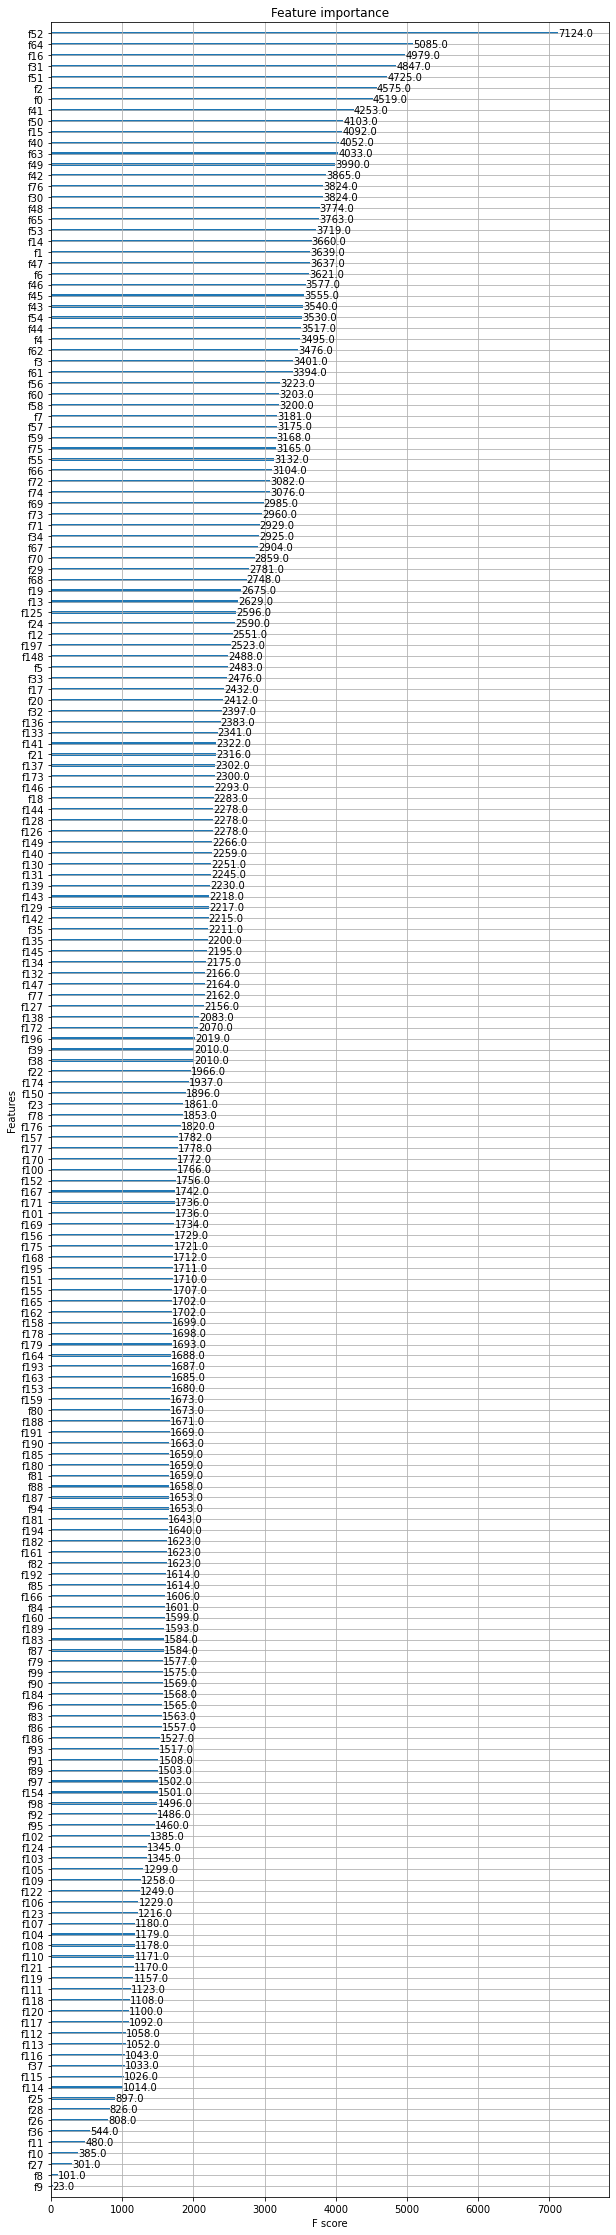

In [7]:
plot_features(xgb_NOx, (10,40))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

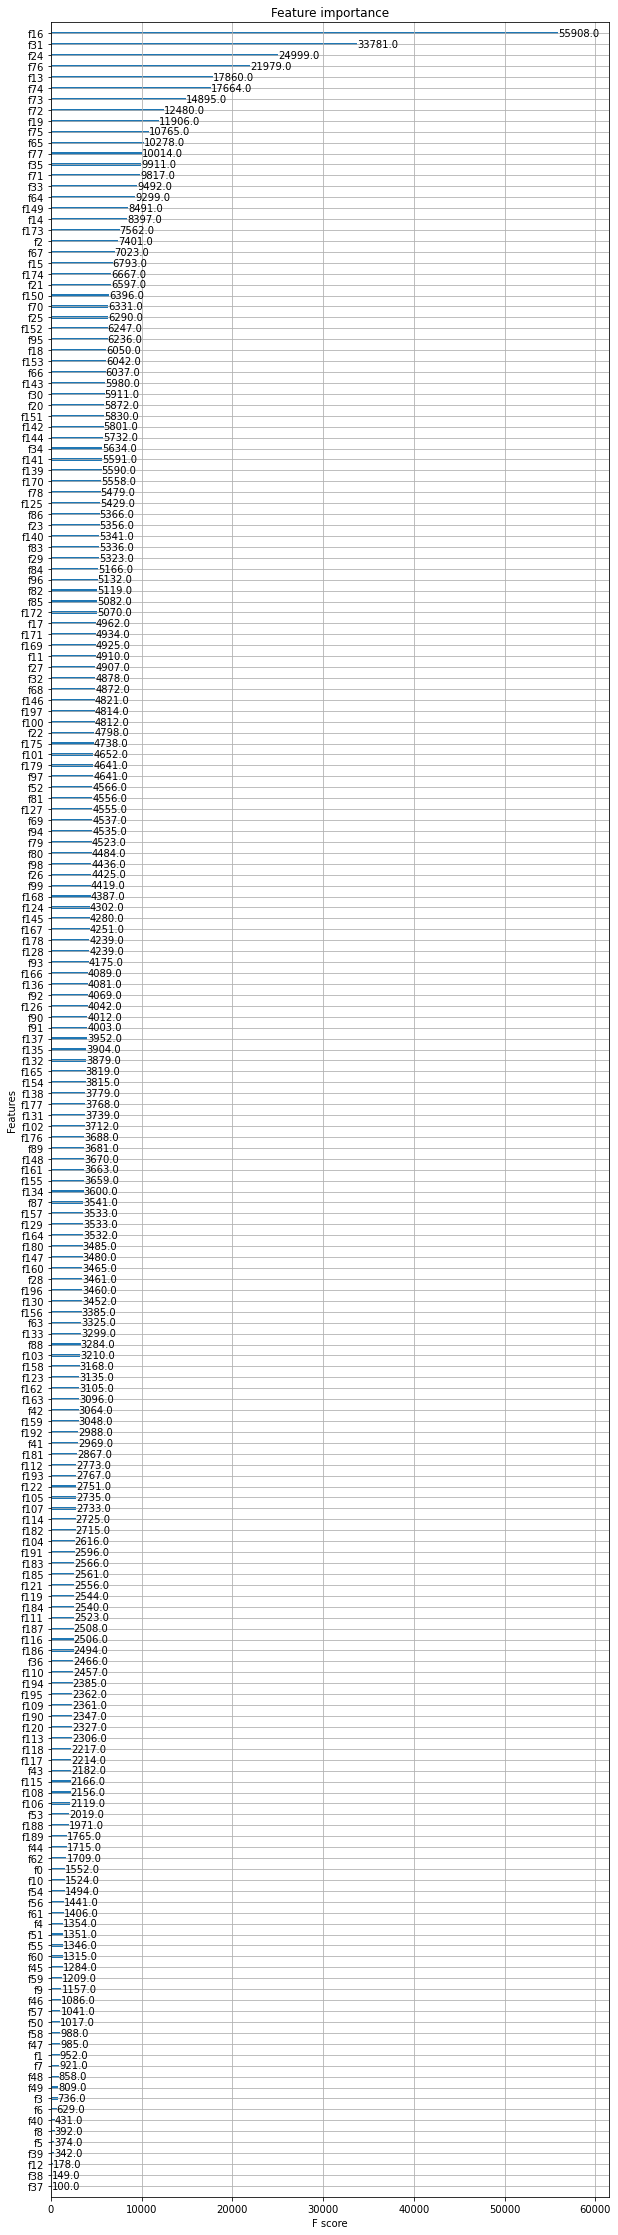

In [9]:
plot_features(xgb_No2, (10,40))